# The Three Body Problem
*By the Space Cadets: Hua En, Edward, Bryan, and Yu En*

## Introduction

The three body problem involves predicting the motion of three gravitationally attracted bodies given their initial positions, velocities and masses. 

Newton's Law of universal gravitation describes the gravitational force between two bodies, while Newton's Second Law states that the net gravitational force on a body is proportional to its net acceleration (full proof is described in the section "Explaining The Computation"). Using these two laws, we can determine how masses gravitationally attract each other and thus change each other's motion.

Up to now, we have a general closed form solution for the motion of two bodies. However, for three bodies, no general solution with finite terms for their motion exists, and we are only able to solve for it numerically. Thus, this project aims to numerically solve, simulate and showcase unique solutions to the three body problems.

One application of the three body problem is to simulate initial satellite conditions for objects to remain in orbit of the earth. 

First, we need to import some packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from IPython.display import HTML
    #You do not need to download the IPython package to make this work, 
    # but it helps in visualisation.

## The Engine

### Define the starting positions and velocities of the planets as numpy arrays, and masses as values.

First, we need to define the starting conditions of the simulation. The three body problem's initial conditions are the positions, velocities and masses of the three objects.

Positions and velocities are described as 3-dimensional numpy arrays containing the x, y and z components of the position or velocity as `np.array(x, y, z)`. For instance, the position of the first object `r1` in three-dimensional space is described as a numpy array containing the x, y and z coordinate of the first object, `np.array(x1, y1, z1)`. Masses are written as values.

All the initial positions (`r`), velocities (`v`) and masses (`m`) of the three bodies are stored as lists (`r_list`, `V_list`, `m_list`) in a dictionary.  
The keys for the dictionaries are initial position (`"r_list"`), initial velocity (`"V_list"`) and mass (`"m_list"`).  
The arrays are in order of the bodies.  

Some special systems are encoded below:

1. Sun-Moon-Earth
  - The sun is the central body and the earth is orbiting around it.
  - The moon is orbiting around the earth.
  - The actual values are used.
 
2. L4 lagrange system  
  - G = 0, stable as long as the ratio of masses between the 2 larger masses exceeds 24.96.
  - The third body is much smaller than the other 2.
  - Each body sits at equilateral triangle
  - Each body follows ellipse but of different angles
  - Common central of mass at focal point of all 3 orbits
  - Same time period for orbit for all 3 bodies

#### Sun, Earth, Moon system:

In [12]:
# Sun, Earth, Moon system
sun_earth_moon_system = {
    "r_list": [
        np.array([0, 0, 0]),          # Position of first body, Sun
        np.array([148.87e9, 0, 0]),   # Position of second body, Earth
        np.array([149.254e9, 0, 0])   # Position of third body, Moon
    ],
    "V_list": [
        np.array([0, 0, 0]),          # Velocity of first body, Sun
        np.array([0, 29800, 0]),      # Velocity of second body, Earth
        np.array([0, 30800, 0])       # Velocity of third body, Moon
    ], 
    "m_list": [
        1.989e30,                     # Mass of first body, Sun
        5.972e24,                     # Mass of second body, Earth
        7.3476e22                     # Mass of third body, Moon
    ]}

# The Sun-Earth-Moon system with all three bodies moving upward at 30km/s
sun_earth_moon_system_vertical = {
    "r_list": [
        np.array([0, 0, 0]),          # Position of first body, Sun
        np.array([148.87e9, 0, 0]),   # Position of second body, Earth
        np.array([149.254e9, 0, 0])   # Position of third body, Moon
    ],
    "V_list": [
        np.array([0, 0, 30000]),      # Velocity of first body, Sun
        np.array([0, 29800, 30000]),  # Velocity of second body, Earth
        np.array([0, 30800, 30000])   # Velocity of third body, Moon
    ], 
    "m_list": [
        1.989e30,                     # Mass of first body, Sun
        5.972e24,                     # Mass of second body, Earth
        7.3476e22                     # Mass of third body, Moon
    ]}

#### Sun, Earth and L4 Lagrange Point

In [11]:
l4_lagrange_system = {
    "r_list": [
        np.array([0, 0, 0]),              # Position of first body, Sun
        np.array([148.87e9, 0, 0]),       # Position of second body, Earth
        np.array([74.435e9, 128.92e9, 0]) # Position of third body, L4
    ],
    "V_list": [
        np.array([0, 0, 0]),              # Velocity of first body, Sun
        np.array([0, 29800, 0]),          # Velocity of second body, Earth
        np.array([-25807, 14900, 0])      # Velocity of third body, L4
    ], 
    "m_list": [
        1.989e30,                         # Mass of first body, Sun
        5.972e24,                         # Mass of second body, Earth
        6000                              # Mass of third body, L4
    ]}

# The L4 Lagrange System with all three bodies moving upwards at 30km/s
l4_lagrange_system_vertical = {
    "r_list": [
        np.array([0, 0, 0]),              # Position of first body, Sun
        np.array([148.87e9, 0, 0]),       # Position of second body, Earth
        np.array([74.435e9, 128.92e9, 0]) # Position of third body, L4
    ],
    "V_list": [
        np.array([0, 0, 30000]),          # Velocity of first body, Sun
        np.array([0, 29800, 30000]),      # Velocity of second body, Earth
        np.array([-25807, 14900, 30000])  # Velocity of third body, L4
    ], 
    "m_list": [
        1.989e30,                         # Mass of first body, Sun
        5.972e24,                         # Mass of second body, Earth
        6000                              # Mass of third body, L4
    ]}

### In order to solve the three body problem...
We need to solve the 3 differential equations of the 3 body problem  numerically, using these differential equations:

$$
\begin{aligned}{\ddot {\mathbf {r} }}_{\mathbf {1} }&=-Gm_{2}{\frac {\mathbf {r_{1}} -\mathbf {r_{2}} }{|\mathbf {r_{1}} -\mathbf {r_{2}} |^{3}}}-Gm_{3}{\frac {\mathbf {r_{1}} -\mathbf {r_{3}} }{|\mathbf {r_{1}} -\mathbf {r_{3}} |^{3}}},\\{\ddot {\mathbf {r} }}_{\mathbf {2} }&=-Gm_{3}{\frac {\mathbf {r_{2}} -\mathbf {r_{3}} }{|\mathbf {r_{2}} -\mathbf {r_{3}} |^{3}}}-Gm_{1}{\frac {\mathbf {r_{2}} -\mathbf {r_{1}} }{|\mathbf {r_{2}} -\mathbf {r_{1}} |^{3}}},\\{\ddot {\mathbf {r} }}_{\mathbf {3} }&=-Gm_{1}{\frac {\mathbf {r_{3}} -\mathbf {r_{1}} }{|\mathbf {r_{3}} -\mathbf {r_{1}} |^{3}}}-Gm_{2}{\frac {\mathbf {r_{3}} -\mathbf {r_{2}} }{|\mathbf {r_{3}} -\mathbf {r_{2}} |^{3}}}.\end{aligned}
$$

The differential equation can be generalised as a single function:

$$
\ddot {\mathbf {r} }_{\mathbf {1} }=-Gm_{2}{\frac {\mathbf {r_{1}} -\mathbf {r_{2}} }{|\mathbf {r_{1}} -\mathbf {r_{2}} |^{3}}}-Gm_{3}{\frac {\mathbf {r_{1}} -\mathbf {r_{3}} }{|\mathbf {r_{1}} -\mathbf {r_{3}} |^{3}}}
$$

Where $\mathbf {r_{1}}$ is the location of the object whose acceleration is being calculated while $\mathbf {r_{2}}, \mathbf {r_{3}}, m_2$ and $m_3$ are the locations and masses of the objects exerting a force on the first object.

This is encoded in a function, `planet_acceleration(rcur, r2, r3, m2, m3, G=6.6743e-11)`, to calculate the acceleration of each body using the differential equation shown above.

A second fuction, `all_planet_acc(r_list, m_list, G=6.6743e-11)`, can be created as well to calculate the individual acceleration of all 3 bodies at a point in time.

In [10]:
def planet_acceleration(rcur, r2, r3, m2, m3, G=6.6743e-11):
    """
    Calculates the acceleration of one of the objects in the three-body system at a point in time.
    rcur, r2, r3 and the returned acceleration are written as numpy arrays np.array([x, y, z]) or np.array([x, y]).

    rcur: The position of the object being accelerated
    r2, m2: The position and mass of the second object
    r3, m3: The position and mass of the third object
    G: Value of the gravitational constant
    """
    return (-G * m2 * (rcur - r2)) / (np.linalg.norm(rcur - r2) ** 3) + (-G * m3 * (rcur - r3)) / (np.linalg.norm(rcur - r3) ** 3)

def all_planet_acc(r_list, m_list, G=6.6743e-11):
    """
    Calculates the accelerations of all 3 objects in the three-body system at a point in time.
    The positions in r_list and the returned accelerations are written as numpy arrays np.array([x, y, z]) or np.array([x, y])
    
    r_list: List of positions of the 3 objects
    m_list: List of masses of the 3 objects
    """
    r1, r2, r3 = r_list
    m1, m2, m3 = m_list
    
    a1 =  planet_acceleration(r1, r2, r3, m2, m3, G)
    a2 =  planet_acceleration(r2, r1, r3, m1, m3, G)
    a3 =  planet_acceleration(r3, r1, r2, m1, m2, G)
    
    return a1, a2, a3

### Solving the Differential Equation numerically

Next, the function `simulate_3_body(initial_system_data, dt, max_time, diff_method, G=6.6743e-11)` is created. It takes in the initial system data(r, v, m), time step, maximum time, the method to calculate the next position of each body and gravitational constant, and solves the differential equation to find the future positions and velocities of the bodies. This is returned as a dict containing the future positions and velocities of the three objects.

In [9]:
def simulate_3_body(initial_system_data, dt, max_time, diff_method, G=6.6743e-11):
    """Simulates the three body problem, given initial starting conditions. 
    This is done through solving the 3 differential equations of the three body problem numerically.
    Returns a dict containing the future positions and velocities of the three bodies over the length of the simulation as well as their corresponding timesteps.

    Args:
        initial_system_data: The initial positions, velocities and masses of the bodies in the system, stored in a dict.
        dt: The size of the time step.
        max_time: The time that the simulation should run for.
        diff_method: The differential method used to solve the differential equations. Provided methods are explicit_euler, semi_implicit_euler and leapfrog.
        G: Gravitational Constant. Defaults to 6.6743e-11.
    """
    # Define Values
    r_list = copy.deepcopy(initial_system_data["r_list"])
    V_list = copy.deepcopy(initial_system_data["V_list"])
    m_list = copy.deepcopy(initial_system_data["m_list"])
    
    # Define dataset
    all_time = np.arange(0, max_time, dt)
    dataset_size = all_time.size

    data = {'time': all_time, 
            'r1': np.empty([dataset_size, 3]), 
            'r2': np.empty([dataset_size, 3]), 
            'r3': np.empty([dataset_size, 3]), 
            'V1': np.empty([dataset_size, 3]), 
            'V2': np.empty([dataset_size, 3]), 
            'V3': np.empty([dataset_size, 3])}

    # Simulation Loop
    for i, time in np.ndenumerate(data['time']):
        # Set current values in dataset
        data['r1'][i] = r_list[0]
        data['r2'][i] = r_list[1]
        data['r3'][i] = r_list[2]
        data['V1'][i] = V_list[0]
        data['V2'][i] = V_list[1]
        data['V3'][i] = V_list[2]

        # Solve differential equation
        r_list, V_list = diff_method(r_list, V_list, m_list, dt, G)
        
    return data

The different numerical methods for solving the differential equation we use are (with increasing accuracy):

  1. Explicit Euler
  2. Semi-Implicit Euler
  3. Leapfrog

These functions return a list of r, v at each time step. 

In [8]:
def explicit_euler(r_list, V_list, m_list, dt, G=6.6743e-11):
    a_list = all_planet_acc(r_list, m_list, G)
    
    new_V_list = []
    new_r_list = []
    
    for r, V, a in zip(r_list, V_list, a_list):
        new_V = V + a * dt
        new_r = r + V * dt
        
        new_V_list.append(new_V)
        new_r_list.append(new_r)
    
    return new_r_list, new_V_list

def semi_implicit_euler(r_list, V_list, m_list, dt, G=6.6743e-11):
    a_list = all_planet_acc(r_list, m_list, G)
    
    new_V_list = []
    new_r_list = []
    
    for r, V, a in zip(r_list, V_list, a_list):
        new_V = V + a * dt
        new_r = r + new_V * dt
        
        new_V_list.append(new_V)
        new_r_list.append(new_r)
    
    return new_r_list, new_V_list
    
# This is also identical to the velocity verlet method
def leapfrog(r_list, V_list, m_list, dt, G=6.6743e-11):
    a_list = all_planet_acc(r_list, m_list, G)
    new_r_list = []

    for r, V, a in zip(r_list, V_list, a_list):
        new_r = r + V * dt + 0.5 * a * (dt ** 2)
        new_r_list.append(new_r)
        
    new_a_list = all_planet_acc(new_r_list, m_list, G)
    new_V_list = []
    
    for V, a, new_a in zip(V_list, a_list, new_a_list):
        new_V = V + 0.5 * (a + new_a) * dt
        new_V_list.append(new_V)
        
    return new_r_list, new_V_list

Now that we have the methods, let's set simulation conditions.

In [7]:
# Simulation Conditions for Sun, Earth, Moon
dt = 1000               # Set dt in seconds
max_time = 31536000     # Set max_time in seconds
G = 6.6743e-11          # Gravitational Constant

In [6]:
# Simulation Conditions for Lagrange Points
dt = 1000
max_time = 31536000
G = 6.6743e-11
    #exact same as the Sun Earth Moon system

And now we can simulate!

In [13]:
data = simulate_3_body(sun_earth_moon_system, dt, max_time, explicit_euler, G) 

This dataset contains the values of position coordinates for the 3 bodies as r1, r2 and r3.

## Visualisation

To make the data easier to read and plot, a new function `process_data(dataset)` is created. The data is extracted according to each body and by x, y, z axis. This processes the dataset of positions into 9 numpy arrays, each describing the change in an individual coordinate of a body over time. For instance, x1 is a numpy array that contains the values of the x coordinate of the first body over time.

In [14]:
def process_data(dataset):
    """
    Process the dataset of positions into 9 numpy arrays, each describing the change in a coordinate of a body over time.
    """
    x1, y1, z1 = data['r1'][:, 0], data['r1'][:, 1], data['r1'][:, 2]
    x2, y2, z2 = data['r2'][:, 0], data['r2'][:, 1], data['r2'][:, 2]
    x3, y3, z3 = data['r3'][:, 0], data['r3'][:, 1], data['r3'][:, 2]
    
    return x1, y1, z1, x2, y2, z2, x3, y3, z3

Then, using matplotlib.pyplot, we are able to use this data to plot a 3D graph to showcase the movement of the 3 bodies over a set time (constrained by `max_time`), given the initial inputs.

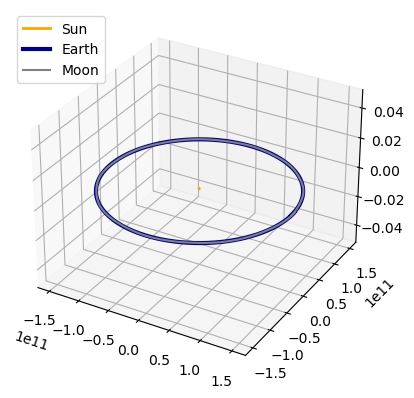

In [15]:
# Process data into the 9 separate coordinates
x1, y1, z1, x2, y2, z2, x3, y3, z3 = process_data(data)

# Plot Data
ax = plt.axes(projection='3d')
ax.plot3D(x1, y1, z1, label="Sun", color="orange", lw=2)
ax.plot3D(x2, y2, z2, label="Earth", color="darkblue", lw=3)
ax.plot3D(x3, y3, z3, label="Moon", color="grey")
ax.legend(loc="upper left")
plt.show()

We can also use `matplotlib.animate` to animate the system!

(-10.0, 10.0)

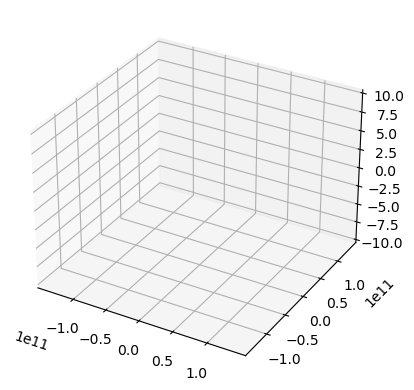

In [16]:
no_of_timesteps = len(data['time'])
animation_frames = 400

# Animate 3D Path
figanim, axanim = plt.subplots(subplot_kw={"projection": "3d"})
line3d1 = axanim.plot([], [], [], label="Sun", color="Orange")
line3d1 = line3d1[0]
point3d1 = axanim.plot([], [], [], ls = "", color = "Orange",  marker = "o")
point3d1 = point3d1[0]

line3d2 = axanim.plot([], [], [], lw=2, label="Earth", color="Darkblue")
line3d2 = line3d2[0]
point3d2 = axanim.plot([], [], [], markersize=5, ls = "", color = "Darkblue",  marker = "o")
point3d2 = point3d2[0]

line3d3 = axanim.plot([], [], [], lw=0.75, label="Moon", color="Grey")
line3d3 = line3d3[0]
point3d3 = axanim.plot([], [], [], markersize=2, ls = "", color = "Grey",  marker = "o")
point3d3 = point3d3[0]

# Axes
# axanim.set_xlim((-50, 250))
# axanim.set_ylim((-30, 40))
# axanim.set_zlim((-30, 60))
axanim.set_xlim((-148.87e9, 148.87e9))
axanim.set_ylim((-148.87e9, 148.87e9))
axanim.set_zlim((-10, 10))

In [17]:
def init():
    line3d1.set_data([], [])
    line3d1.set_3d_properties([])
    
    line3d2.set_data([], [])
    line3d2.set_3d_properties([])
    
    line3d3.set_data([], [])
    line3d3.set_3d_properties([])
    
    return line3d1, line3d2, line3d3

def animate(i):
    j = i * (no_of_timesteps // animation_frames)
    
    line3d1.set_data(x1[:j], y1[:j])
    line3d1.set_3d_properties(z1[:j])
    point3d1.set_data(x1[j-1:j], y1[j-1:j])
    point3d1.set_3d_properties(z1[j-1:j])
    
    line3d2.set_data(x2[:j], y2[:j])
    line3d2.set_3d_properties(z2[:j])
    point3d2.set_data(x2[j-1:j], y2[j-1:j])
    point3d2.set_3d_properties(z2[j-1:j])
    
    line3d3.set_data(x3[:j], y3[:j])
    line3d3.set_3d_properties(z3[:j])
    point3d3.set_data(x3[j-1:j], y3[j-1:j])
    point3d3.set_3d_properties(z3[j-1:j])
    
    # figanim.canvas.draw()
    return line3d1, line3d2, point3d2, line3d3

In [18]:
# Animating
anim = animation.FuncAnimation(figanim, animate, init_func=init, frames=animation_frames, interval=30, blit=True)

# Labels
axanim.grid(alpha=0.25)
axanim.legend(loc='upper left')
axanim.set_title("The Sun-Earth-Moon System")
axanim.set_xlabel('x')
axanim.set_ylabel('y')
axanim.set_zlabel('z')

# Save
anim.save("thethreebodies.mp4", fps=15)

# Visualise in jupyter with IPython
from IPython.display import HTML
HTML(anim.to_html5_video())

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

*Note: View the animation output as an .mp4 video from the folder itself. If you would like to view the animation within Jupyter Notebook, download the IPython package and import the IPython package as shown in the 1st coding cell.*

## Analysis

### Example 1: The Sun-Earth-Moon System

Lets visualise the inputs of the Sun, Earth, Moon system as an example:

In [ ]:
#----------------------------------------- Set conditions ----------------------------------------#
dt = 1000               # Set dt in seconds
max_time = 31536000     # Set max_time in seconds
G = 6.6743e-11          # Gravitational Constant

#---------------------------------- Simulation and process data ----------------------------------#
data = simulate_3_body(sun_earth_moon_system, dt, max_time, explicit_euler, G) 

x1, y1, z1, x2, y2, z2, x3, y3, z3 = process_data(data)

#-------------------------------------------- Animate --------------------------------------------#
no_of_timesteps = len(data['time'])
animation_frames = 400

# Animate 3D Path
figanim, axanim = plt.subplots(subplot_kw={"projection": "3d"})
line3d1 = axanim.plot([], [], [], label="Sun", color="Orange")
line3d1 = line3d1[0]
point3d1 = axanim.plot([], [], [], ls = "", color = "Orange",  marker = "o")
point3d1 = point3d1[0]

line3d2 = axanim.plot([], [], [], lw=2, label="Earth", color="Darkblue")
line3d2 = line3d2[0]
point3d2 = axanim.plot([], [], [], markersize=5, ls = "", color = "Darkblue",  marker = "o")
point3d2 = point3d2[0]

line3d3 = axanim.plot([], [], [], lw=0.75, label="Moon", color="Grey")
line3d3 = line3d3[0]
point3d3 = axanim.plot([], [], [], markersize=2, ls = "", color = "Grey",  marker = "o")
point3d3 = point3d3[0]

# Axes
axanim.set_xlim((-148.87e9, 148.87e9))
axanim.set_ylim((-148.87e9, 148.87e9))
axanim.set_zlim((-10, 10))

# Animating
anim = animation.FuncAnimation(figanim, animate, init_func=init, frames=animation_frames, interval=30, blit=True)

# Labels
axanim.grid(alpha=0.25)
axanim.legend(loc='upper left')
axanim.set_title("The Sun-Earth-Moon System")
axanim.set_xlabel('x')
axanim.set_ylabel('y')
axanim.set_zlabel('z')

# Save
anim.save("SunEarthMoon_Example.mp4", fps=15)

# Visualise in jupyter with IPython
HTML(anim.to_html5_video())

### Example 2: The Sun-Earth-L4 Point System

In this example, we will visualise the motion of the Sun, Earth and an object at the L4 Lagrange Point of the Sun and Earth. However, this time, all 3 objects will be moving upwards.

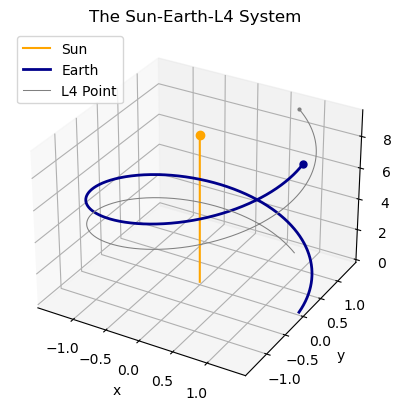

In [16]:
#----------------------------------------- Set conditions ----------------------------------------#
dt = 1000               # Set dt in seconds
max_time = 31536000     # Set max_time in seconds
G = 6.6743e-11          # Gravitational Constant

#---------------------------------- Simulation and process data ----------------------------------#
data = simulate_3_body(l4_lagrange_system_vertical, dt, max_time, explicit_euler, G) 

x1, y1, z1, x2, y2, z2, x3, y3, z3 = process_data(data)

#-------------------------------------------- Animate --------------------------------------------#
no_of_timesteps = len(data['time'])
animation_frames = 400

# Animate 3D Path
figanim, axanim = plt.subplots(subplot_kw={"projection": "3d"})
line3d1 = axanim.plot([], [], [], label="Sun", color="Orange")
line3d1 = line3d1[0]
point3d1 = axanim.plot([], [], [], ls = "", color = "Orange",  marker = "o")
point3d1 = point3d1[0]

line3d2 = axanim.plot([], [], [], lw=2, label="Earth", color="Darkblue")
line3d2 = line3d2[0]
point3d2 = axanim.plot([], [], [], markersize=5, ls = "", color = "Darkblue",  marker = "o")
point3d2 = point3d2[0]

line3d3 = axanim.plot([], [], [], lw=0.75, label="L4 Point", color="Grey")
line3d3 = line3d3[0]
point3d3 = axanim.plot([], [], [], markersize=2, ls = "", color = "Grey",  marker = "o")
point3d3 = point3d3[0]

# Axes
axanim.set_xlim((-148.87e9, 148.87e9))
axanim.set_ylim((-148.87e9, 148.87e9))
axanim.set_zlim((0, 30000 * max_time))

# Animating
anim = animation.FuncAnimation(figanim, animate, init_func=init, frames=animation_frames, interval=30, blit=True)

# Labels
axanim.grid(alpha=0.25)
axanim.legend(loc='upper left')
axanim.set_title("The Sun-Earth-L4 System")
axanim.set_xlabel('x')
axanim.set_ylabel('y')
axanim.set_zlabel('z')

# Save
anim.save("SunEarthL4_Example.mp4", fps=15)

# Visualise in jupyter with IPython
HTML(anim.to_html5_video())

## Try it out for yourself!

**Under construction !!!**

In [17]:


dt=float(input("dt: "))
max_time=float(input("Max time: "))
G=float(input("G: "))

numberof_points=max_time/dt
print(f'a total of {numberof_points} points were plotted per body')

dt: 0.1
Max time: 10
G: 1
a total of 100.0 points were plotted per body


*For reference, for the sun, earth, moon system has:*
- *Body 1: *
- *Body 2: *
- *Body 3: *
- *dt = 1000,*
- *max_time = 31536000,*
- *G = 6.6743e-11*

## Explaining The Computation

Newton’s second law and Newton’s Law of Universal Gravitation is given as follows:  

$$
\begin{align}
F & = ma \\
F & = -G \frac{m_{1}m_{2}}{r^2}
\end{align}
$$

Their vector forms are as follows:  

$$
\begin{align}
\mathbf{F_{1}} &= m_{1} \mathbf{\ddot{r}_{1}} \\
\mathbf{F_{12}} &= -G \frac{m_{1}m_{2}}{\left| \mathbf{r_{12}} \right|^2 }\, \mathbf{\hat{r}_{12}}
\end{align}
$$

Where $\mathbf{F_{1}}$ and $\mathbf{\ddot{r}_{1}}$ are the force and acceleration of mass $m_{1}$ respectively, and $\mathbf{F}_{12}$ is the gravitational force exerted on mass $m_{1}$ by mass $m_{2}$.  

The gravitational force $\mathbf{F_{12}}$ can be further expanded as follows:  

$$
\begin{align}
\mathbf{F_{12}} = -G \frac{m_{1}m_{2}}{\left| \mathbf{r_{12}} \right|^2 }\, \mathbf{\hat{r}_{12}} = -Gm_{1}m_{2} \frac{\mathbf{r_{1}} - \mathbf{r_{2}}}{\left| \mathbf{r_{1}} - \mathbf{r_{2}} \right|^3 } \, 
\end{align}
$$

In a three body system, each mass $m_{1}$, $m_{2}$, $m_{3}$ experiences a gravitational force from the other two masses by Newton’s Law of Universal Gravitation. Thus the total force exerted on mass $m_{1}$ by the other two masses can be expressed as follows:  

$$
\mathbf{F_{1}} = \mathbf{F_{12}} + \mathbf{F_{13}}
$$

Expanding this expression:  

$$
\begin{align}
m_{1}\mathbf{\ddot{r}_{1}} &= -Gm_{1}m_{2} \frac{\mathbf{r_{1}} - \mathbf{r_{2}}}{\left| \mathbf{r_{1}} - \mathbf{r_{2}} \right|^3 } - Gm_{1}m_{3} \frac{\mathbf{r_{1}} - \mathbf{r_{3}}}{\left| \mathbf{r_{1}} - \mathbf{r_{3}} \right|^3 } \\
\mathbf{\ddot{r}_{1}} &= -Gm_{2} \frac{\mathbf{r_{1}} - \mathbf{r_{2}}}{\left| \mathbf{r_{1}} - \mathbf{r_{2}} \right|^3 } - Gm_{3} \frac{\mathbf{r_{1}} - \mathbf{r_{3}}}{\left| \mathbf{r_{1}} - \mathbf{r_{3}} \right|^3 }
\end{align}
$$

Repeating this process for the other two masses $m_{2}$ and $m_{3}$, we obtain the three differential equations for the three body problem:  

$$
\begin{aligned}{\ddot {\mathbf {r} }}_{\mathbf {1} }&=-Gm_{2}{\frac {\mathbf {r_{1}} -\mathbf {r_{2}} }{|\mathbf {r_{1}} -\mathbf {r_{2}} |^{3}}}-Gm_{3}{\frac {\mathbf {r_{1}} -\mathbf {r_{3}} }{|\mathbf {r_{1}} -\mathbf {r_{3}} |^{3}}},\\{\ddot {\mathbf {r} }}_{\mathbf {2} }&=-Gm_{3}{\frac {\mathbf {r_{2}} -\mathbf {r_{3}} }{|\mathbf {r_{2}} -\mathbf {r_{3}} |^{3}}}-Gm_{1}{\frac {\mathbf {r_{2}} -\mathbf {r_{1}} }{|\mathbf {r_{2}} -\mathbf {r_{1}} |^{3}}},\\{\ddot {\mathbf {r} }}_{\mathbf {3} }&=-Gm_{1}{\frac {\mathbf {r_{3}} -\mathbf {r_{1}} }{|\mathbf {r_{3}} -\mathbf {r_{1}} |^{3}}}-Gm_{2}{\frac {\mathbf {r_{3}} -\mathbf {r_{2}} }{|\mathbf {r_{3}} -\mathbf {r_{2}} |^{3}}}.\end{aligned}
$$